In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import numpy as np

sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 500)

In [2]:
# timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,cpu_percent,avg_text,avg_data,peak_rss,inputs,outputs,minor_pagefaults,major_pagefaults,swaps,alloc_mem,reclaimed_mem,rts_mem,total_gcs,minor_gcs,major_gcs,avg_mem,max_mem,n_samples,init_cpu,init_sys,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance
data_files_45 = [
    '../data/results_45_1.csv',
    '../data/results_45_2.csv'
]

df_45 = pd.concat(map(lambda file: pd.read_csv(file), data_files_45))
df_45['total_energy'] = df_45['pkg_energy'] + df_45['dram_energy']

data_files_65 = [
    '../data/results_65_1.csv',
    '../data/results_65_2.csv'
]

df_65 = pd.concat(map(lambda file: pd.read_csv(file), data_files_65))
df_65['total_energy'] = df_65['pkg_energy'] + df_65['dram_energy']

data_files_55 = [
    '../data/results_55_1.csv',
    '../data/results_55_2.csv'
]

df_55 = pd.concat(map(lambda file: pd.read_csv(file), data_files_55))
df_55['total_energy'] = df_55['pkg_energy'] + df_55['dram_energy']

# display(df.head(5))

progs = df_55['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df_55['flag'].unique()
print(f"Flags ({len(flags)}): {flags}")

Programs (18): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'fannkuch-redux' 'binary-trees' 'n-body' 'pidigits' 'reverse-complement'
 'spectral-norm' 'callback001' 'chan' 'power' 'treejoin']
Flags (27): ['-O2' '-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case'
 '-funfolding-use-threshold=40' '-funfolding-use-threshold=160']


In [3]:
def calculate_increase(df1, df2, column):
    new_dataframe = []

    for flag in flags:
        for prog in progs:
            base_mean = df1[(df1['flag'] == flag) & (df1['program'] == prog)][column].mean()
            diff_mean = df2[(df2['flag'] == flag) & (df2['program'] == prog)][column].mean()
            
            increase = ((diff_mean - base_mean) / base_mean) * 100
            
            new_dataframe.append([prog, flag, base_mean, diff_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'diff_mean', 'increase'])

,program,flag,base_mean,diff_mean,increase
15,chan,-O2,271369.35,318433.15,17.343079


,program,flag,base_mean,diff_mean,increase
385,fluid,-fno-strictness,1047860.975,1039142.2,-0.832055


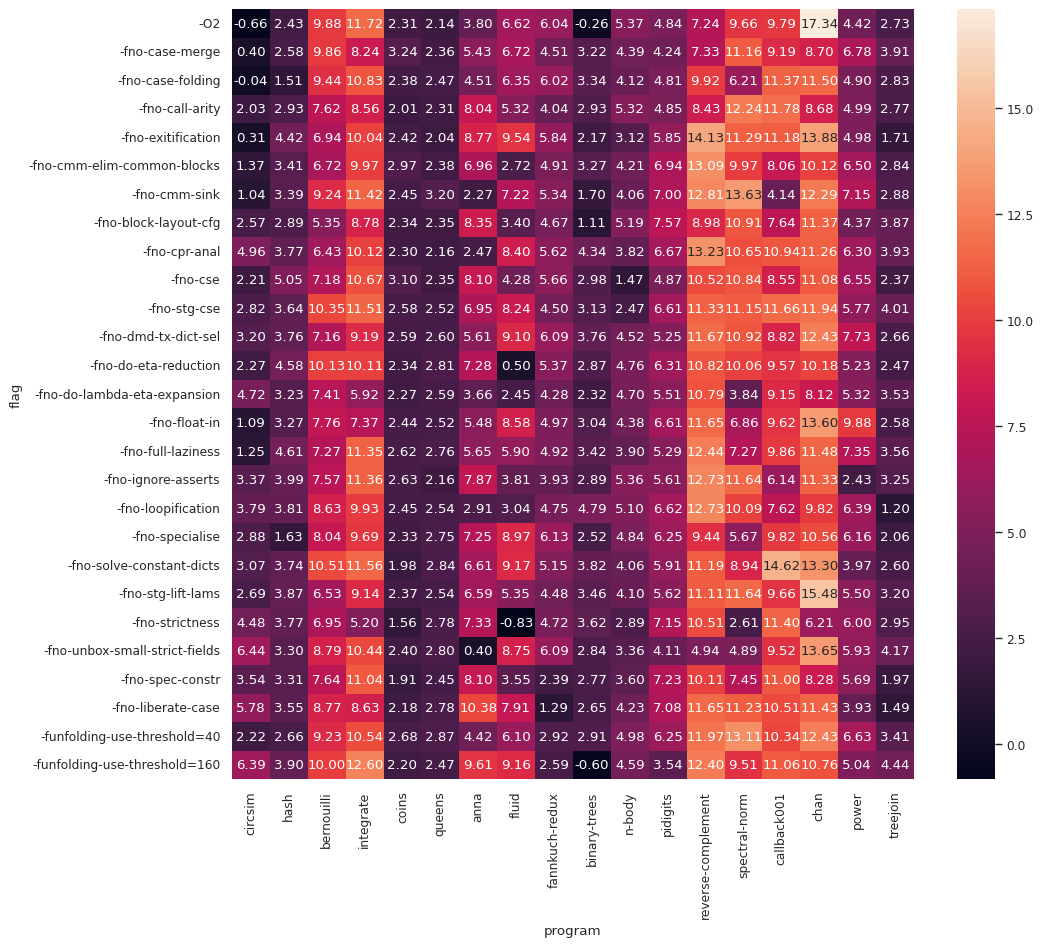

In [4]:
data_col = 'total_energy'
increase_df = calculate_increase(df_55, df_65, data_col)

display(increase_df[increase_df.increase == increase_df.increase.max()])
display(increase_df[increase_df.increase == increase_df.increase.min()])

# display(increase_df[increase_df.increase <= 0])

plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)

# plt.savefig(f"../charts/{data_col}_temperature_heat.pdf", bbox_inches='tight')
plt.show()

In [5]:
data_col = 'total_energy'

inc_dfs = [calculate_increase(df1, df2, data_col) for df1, df2 in [(df_45, df_55), (df_55, df_65)]]
temp_labels = [(45,55), (55,65)]

max_inc = max([max(inc_df['increase']) for inc_df in inc_dfs])
min_inc = min([min(inc_df['increase']) for inc_df in inc_dfs])

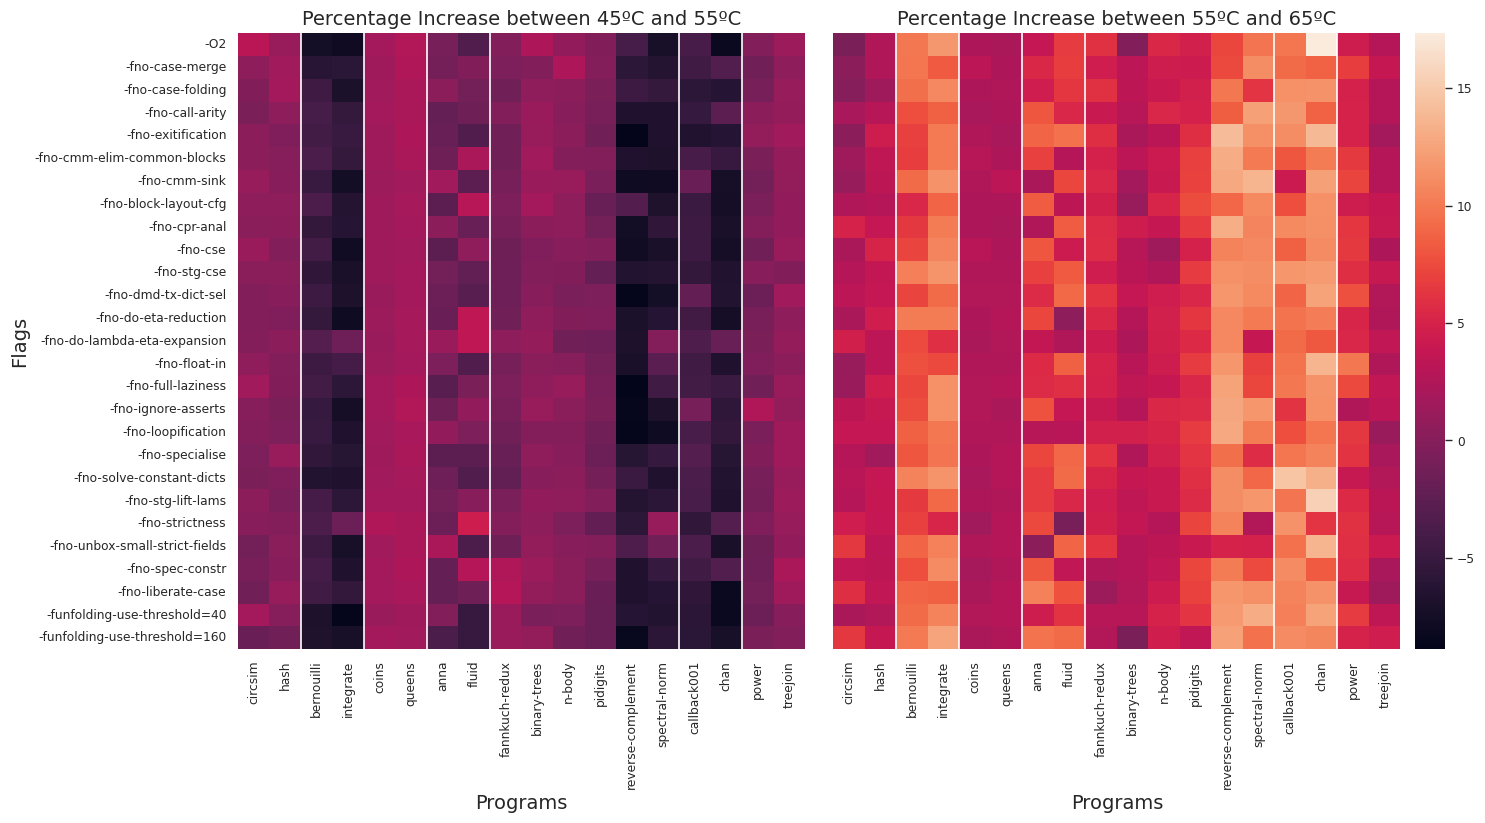

In [6]:
fig, axis = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(15, 8))
cbar_ax = fig.add_axes([.91, .11, .02, .77])

for i, inc_df in enumerate(inc_dfs):
    ax = axis[i]
    
    sns.heatmap(
        ax=ax,
        data = inc_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
        # annot = inc_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
        fmt='.2f',
        vmax=max_inc,
        vmin=min_inc,
        cbar_ax=cbar_ax
    )
    
    ax.set_ylabel('')
    ax.set_xlabel('Programs', fontsize=14)
    ax.set_title(f'Percentage Increase between {temp_labels[i][0]}ºC and {temp_labels[i][1]}ºC', fontsize=14)
    
    
    if i == 0: ax.set_ylabel('Flags', fontsize=14)
    
    ax.vlines([2,4,6,8,14,16], *ax.get_ylim(), colors="white")

plt.subplots_adjust(wspace=0.05)

plt.show()

In [9]:
np.average(inc_dfs[0]['base_mean'])

2485690.2816358022

In [12]:
np.average(inc_dfs[0]['diff_mean'])


2502110.994855967

In [13]:
np.average(inc_dfs[1]['diff_mean'])


2588643.3211934157

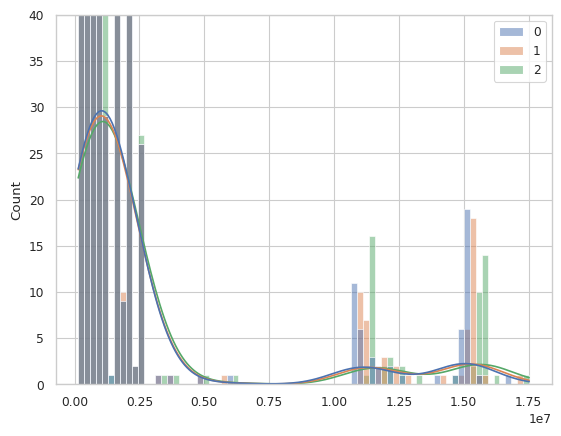

In [19]:
sns.histplot([inc_dfs[0]['base_mean'].values, inc_dfs[0]['diff_mean'].values, inc_dfs[1]['diff_mean'].values], kde=True)
plt.ylim(0,40)
plt.show()